<a href="https://colab.research.google.com/github/pravvvv/Amazon_fine_food_reviews/blob/main/Amazon_fine_food_reviews_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# Reading Data

## Loading data

The dataset is available in two forms
1. .csv file
2. SQLite Database

SQLITE dataset was used to query the data 

We ensure the Score>3 is positive and Score<3 is set as negative . We ignore the score = 3

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import classification_report
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import normalize
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn import datasets, neighbors
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os

C:\Users\pmallya1\AppData\Local\Continuum\Anaconda3-5.2.0\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pmallya1\AppData\Local\Continuum\Anaconda3-5.2.0\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#  Preprocessing

Steps planned for preprocessing:
* Remove html tags
* Remove punctuations, special characters
* Check for alpha numeric (avoid in most cases)
* Words have to be >2 length
* Convert to lowercase
* Remove stopwords
* Snowball Stemming

# Vectorization steps 

In [ ]:
#normalize
def k_vs_AUC_CV_Train(neighbors,mean_auc_train,mean_auc_cv):
        plt.plot(neighbors[:],mean_auc_train[0:],color='b', label='Train')
        plt.plot(neighbors[:],mean_auc_cv[0:],color='r', label='CV')
        plt.title("K vs AUC" )
        plt.xlabel("K")
        plt.ylabel("AUC")
        plt.legend()
        plt.ylim(0, 1)
        plt.show()
def knn_apply(neighbors,X_tr,X_cv,y_tr,y_cv,algo):
    cv_scores = []
    mean_auc_train = []
    mean_auc_cv = []
    n = 10
    for k in tqdm(neighbors):
        # for each iteration, randomly hold out 20% of the data as CV set
        clf = KNeighborsClassifier(n_neighbors=k, algorithm=algo)
        clf.fit(X_tr, y_tr)
        pred_train = clf.predict_proba(X_tr)
        pred_cv = clf.predict_proba(X_cv)
        mean_auc_cv.append(roc_auc_score(y_cv, pred_cv[:,1]))
        mean_auc_train.append(roc_auc_score(y_tr, pred_train[:,1]))

    df = pd.DataFrame({
        'k' : neighbors,
        'AUC_CV' : mean_auc_cv,
        'AUC_train' : mean_auc_train
    })
    return df

In [ ]:
def test_results(best_k,X_train_ncv, X_cv, X_test,y_train_ncv, y_cv,y_test,algo):
    clf = KNeighborsClassifier(n_neighbors=best_k, algorithm=algo)
    clf.fit(X_train_ncv, y_train_ncv)
    pred_train = clf.predict_proba(X_train_ncv)
    pred_cv = clf.predict_proba(X_cv)
    pred_test = clf.predict_proba(X_test)
    fpr1, tpr1, thresholds = roc_curve(y_train_ncv, pred_train[:,1])
    fpr2, tpr2, thresholds = roc_curve(y_cv, pred_cv[:,1])
    fpr3, tpr3, thresholds = roc_curve(y_test, pred_test[:,1])
    print("The AUC score for train data is : ",roc_auc_score(y_train_ncv, pred_train[:,1]))
    print("The AUC score for CV data is : ",roc_auc_score(y_cv, pred_cv[:,1]))
    print("The AUC score for test data is : ",roc_auc_score(y_test, pred_test[:,1]))
    plt.plot(fpr1,tpr1,'r',label = 'Train data')
    plt.plot(fpr2,tpr2,'b',label = 'CV data')
    plt.plot(fpr3,tpr3,'g',label = 'Test data')
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    plt.show()
    import seaborn as sn
    #https://stackoverflow.com/questions/47264597/confusion-matrix-from-probabilities
    import matplotlib.pyplot as plt1
    y_pred = np.argmax(pred_test, axis=1)
    conf_mat = confusion_matrix(y_test, y_pred )
    conf_mat_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
    sn.heatmap(conf_mat , annot=True , fmt='.1f'  )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print(classification_report(y_test, y_pred))

# BoW

#### KNN - Brute force

In [ ]:
neighbors = list(range(1, 40, 2))
X_tr = X_tr_bow_500
X_te = X_te_bow_500
X_cv = X_cv_500
knn_df = knn_apply(neighbors,X_tr, X_cv, y_train_ncv, y_cv,'brute')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [15:14<00:00, 45.73s/it]


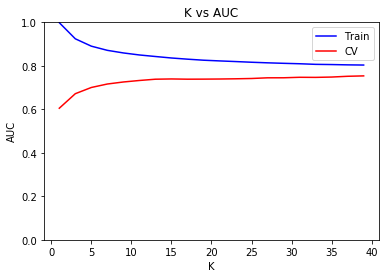

39 is the optimal k 


In [ ]:

k_vs_AUC_CV_Train(neighbors,knn_df['AUC_train'],knn_df['AUC_CV'])
best_k_row = knn_df.loc[knn_df['AUC_CV'] == max(knn_df['AUC_CV'] )]
best_k = int(best_k_row.iloc[0]['k'])
print(str(best_k) + " is the optimal k ")



The AUC score for train data is :  0.803705493110363
The AUC score for CV data is :  0.7538204585631113
The AUC score for test data is :  0.7516767948524985


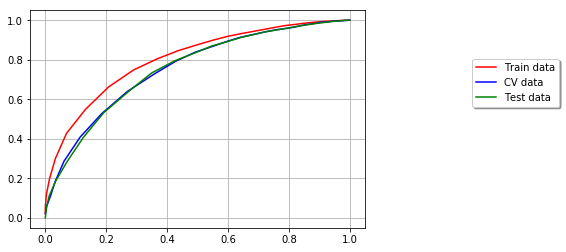

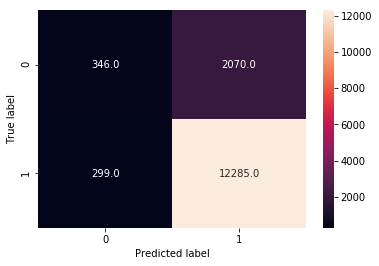

             precision    recall  f1-score   support

          0       0.54      0.14      0.23      2416
          1       0.86      0.98      0.91     12584

avg / total       0.80      0.84      0.80     15000



In [ ]:
test_results(best_k,X_tr,X_cv,X_te,y_train_ncv,y_cv,y_test,'brute')

#### KNN-KDTree

In [ ]:
#convert sparse matrix to dense for kd_tree

import scipy

print(scipy.sparse.issparse(X_tr_bow_500))
X_tr = X_tr_bow_500.toarray()
X_te = X_te_bow_500.toarray()
X_cv = X_cv_500.toarray()

print(scipy.sparse.issparse(X_tr))

True
False


In [ ]:
neighbors = list(range(1, 40, 2))
knn_df = knn_apply(neighbors,X_tr, X_cv, y_train_ncv, y_cv,'kd_tree')

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [5:30:27<00:00, 991.36s/it]


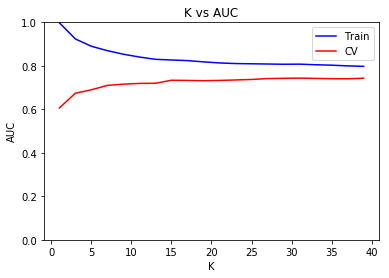

31 is the optimal k 


In [ ]:

k_vs_AUC_CV_Train(neighbors,knn_df['AUC_train'],knn_df['AUC_CV'])
best_k_row = knn_df.loc[knn_df['AUC_CV'] == max(knn_df['AUC_CV'] )]
best_k = int(best_k_row.iloc[0]['k'])
print(str(best_k) + " is the optimal k ")



In [ ]:
X_tr = X_tr_bow_500.toarray()
X_te = X_te_bow_500.toarray()
X_cv = X_cv_500.toarray()
best_k = 31

The AUC score for train data is :  0.807839663315454
The AUC score for CV data is :  0.743618933502104
The AUC score for test data is :  0.7402180032302135


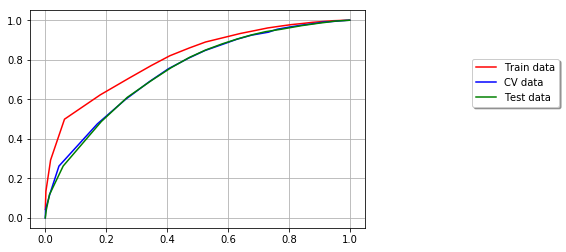

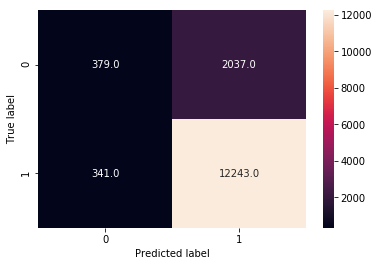

             precision    recall  f1-score   support

          0       0.53      0.16      0.24      2416
          1       0.86      0.97      0.91     12584

avg / total       0.80      0.84      0.80     15000



In [ ]:
test_results(best_k,X_tr,X_cv,X_te,y_train_ncv,y_cv,y_test,'kd_tree')

# TFIDF

### KNN-Bruteforce

In [ ]:
X_tr = X_tr_tfidf_500 
X_te = X_te_tdidf_500
X_cv = X_cv_tdidf_500 


neighbors = list(range(1, 40, 2))
knn_df = knn_apply(neighbors,X_tr, X_cv, y_train_ncv, y_cv,'brute')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [13:28<00:00, 40.42s/it]


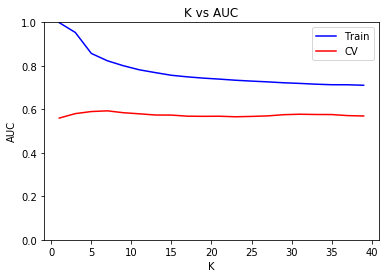

7 is the optimal k 


In [ ]:
k_vs_AUC_CV_Train(neighbors,knn_df['AUC_train'],knn_df['AUC_CV'])
best_k_row = knn_df.loc[knn_df['AUC_CV'] == max(knn_df['AUC_CV'] )]
best_k = int(best_k_row.iloc[0]['k'])
print(str(best_k) + " is the optimal k ")

The AUC score for train data is :  0.8233785696865328
The AUC score for CV data is :  0.5930926409411448
The AUC score for test data is :  0.577119242136551


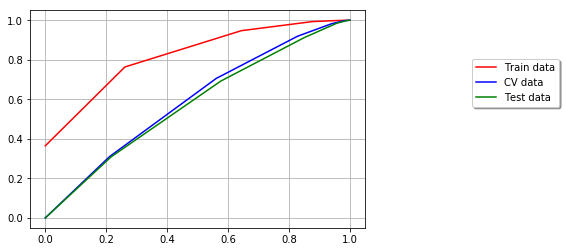

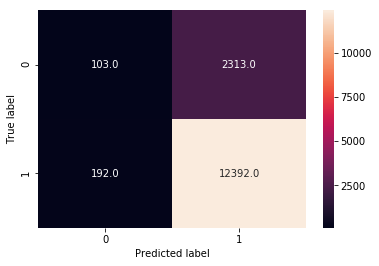

             precision    recall  f1-score   support

          0       0.35      0.04      0.08      2416
          1       0.84      0.98      0.91     12584

avg / total       0.76      0.83      0.77     15000



In [ ]:
test_results(best_k,X_tr,X_cv,X_te,y_train_ncv,y_cv,y_test,'brute')

### KNN-KDTree

In [ ]:
#convert sparse matrix to dense for kd_tree

import scipy

print(scipy.sparse.issparse(X_tr_bow_500))
X_tr = X_tr_tfidf_500.toarray()
X_te = X_te_tdidf_500.toarray()
X_cv = X_cv_tdidf_500.toarray()

print(scipy.sparse.issparse(X_tr))

True
False


In [ ]:
neighbors = list(range(1, 40, 2))
knn_df = knn_apply(neighbors,X_tr, X_cv, y_train_ncv, y_cv,'kd_tree')

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [4:38:30<00:00, 835.55s/it]


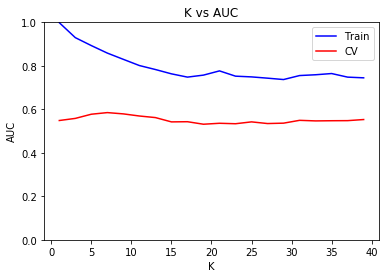

7 is the optimal k 


In [ ]:
k_vs_AUC_CV_Train(neighbors,knn_df['AUC_train'],knn_df['AUC_CV'])
best_k_row = knn_df.loc[knn_df['AUC_CV'] == max(knn_df['AUC_CV'] )]
best_k = int(best_k_row.iloc[0]['k'])
print(str(best_k) + " is the optimal k ")

The AUC score for train data is :  0.8586277720950636
The AUC score for CV data is :  0.5849764557673461
The AUC score for test data is :  0.5718413979909314


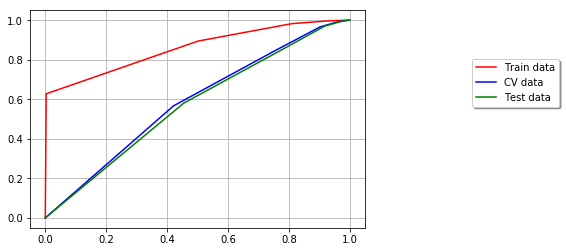

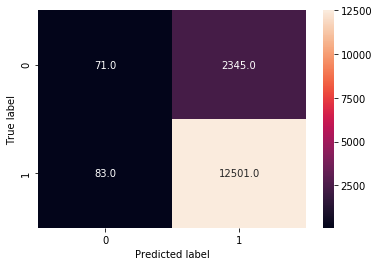

             precision    recall  f1-score   support

          0       0.46      0.03      0.06      2416
          1       0.84      0.99      0.91     12584

avg / total       0.78      0.84      0.77     15000



In [ ]:
test_results(best_k,X_tr,X_cv,X_te,y_train_ncv,y_cv,y_test,'kd_tree')

# AVG W2V

### KNN-Brute Force

In [ ]:
X_tr = X_tr_avgw2v
X_te = X_te_avgw2v
X_cv = X_cv_avgw2v
neighbors = list(range(1, 40, 2))
knn_df = knn_apply(neighbors,X_tr, X_cv, y_train_ncv, y_cv,'brute')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:45<00:00, 20.28s/it]


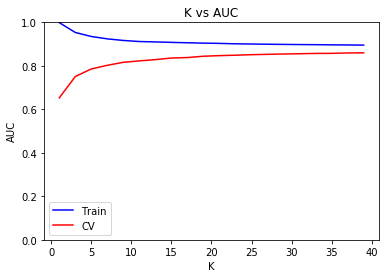

39 is the optimal k 


In [ ]:
# Please write all the code with proper documentation
k_vs_AUC_CV_Train(neighbors,knn_df['AUC_train'],knn_df['AUC_CV'])
best_k_row = knn_df.loc[knn_df['AUC_CV'] == max(knn_df['AUC_CV'] )]
best_k = int(best_k_row.iloc[0]['k'])
print(str(best_k) + " is the optimal k ")

The AUC score for train data is :  0.8954220718765613
The AUC score for CV data is :  0.8598821677507061
The AUC score for test data is :  0.8666216666385992


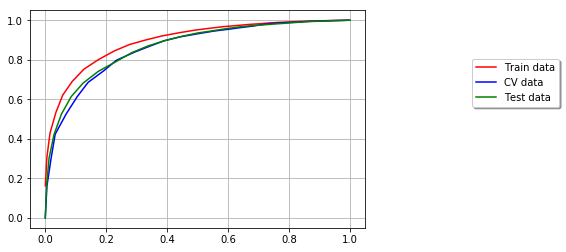

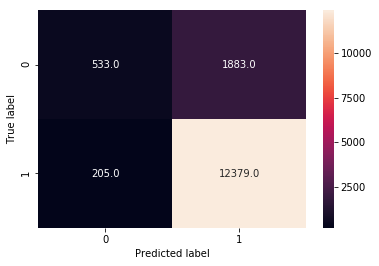

             precision    recall  f1-score   support

          0       0.72      0.22      0.34      2416
          1       0.87      0.98      0.92     12584

avg / total       0.84      0.86      0.83     15000



In [ ]:
test_results(best_k,X_tr,X_cv,X_te,y_train_ncv,y_cv,y_test,'brute')


### KNN-Kdtree

In [ ]:


X_tr = X_tr_avgw2v
X_te = X_te_avgw2v
X_cv = X_cv_avgw2v

In [ ]:
neighbors = list(range(1, 40, 2))
knn_df = knn_apply(neighbors,X_tr, X_cv, y_train_ncv, y_cv,'kd_tree')

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [36:56<00:00, 110.81s/it]


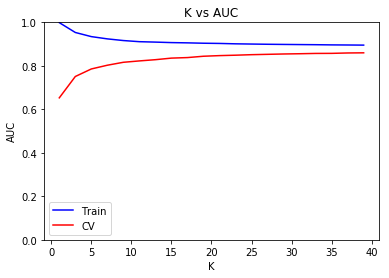

39 is the optimal k 


In [ ]:
# Please write all the code with proper documentation
k_vs_AUC_CV_Train(neighbors,knn_df['AUC_train'],knn_df['AUC_CV'])
best_k_row = knn_df.loc[knn_df['AUC_CV'] == max(knn_df['AUC_CV'] )]
best_k = int(best_k_row.iloc[0]['k'])
print(str(best_k) + " is the optimal k ")

The AUC score for train data is :  0.8953325274061567
The AUC score for CV data is :  0.8599057360019599
The AUC score for test data is :  0.8668709023705071


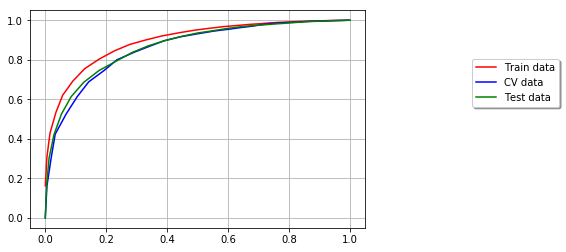

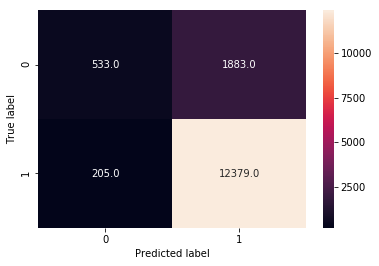

             precision    recall  f1-score   support

          0       0.72      0.22      0.34      2416
          1       0.87      0.98      0.92     12584

avg / total       0.84      0.86      0.83     15000



In [ ]:
test_results(best_k,X_tr,X_cv,X_te,y_train_ncv,y_cv,y_test,'kd_tree')


# TFIDF W2V

### KNN-Bruteforce

In [ ]:
X_tr = X_tr_tfidfw2v
X_te = X_test_tfidfw2v
X_cv = X_cv_tfidfw2v

neighbors = list(range(1, 40, 2))
knn_df = knn_apply(neighbors,X_tr, X_cv, y_train_ncv, y_cv,'brute')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:01<00:00, 21.07s/it]


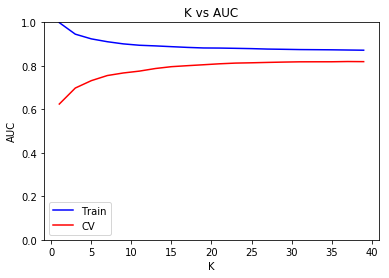

37 is the optimal k 


In [ ]:
# Please write all the code with proper documentation
k_vs_AUC_CV_Train(neighbors,knn_df['AUC_train'],knn_df['AUC_CV'])
best_k_row = knn_df.loc[knn_df['AUC_CV'] == max(knn_df['AUC_CV'] )]
best_k = int(best_k_row.iloc[0]['k'])
print(str(best_k) + " is the optimal k ")

The AUC score for train data is :  0.8728127373554891
The AUC score for CV data is :  0.8198415853236747
The AUC score for test data is :  0.8263227732156464


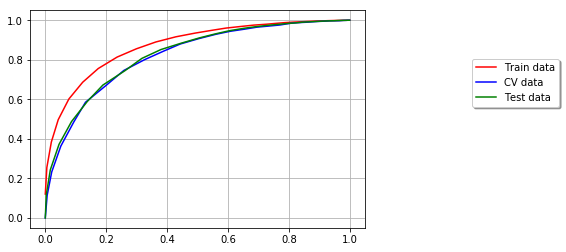

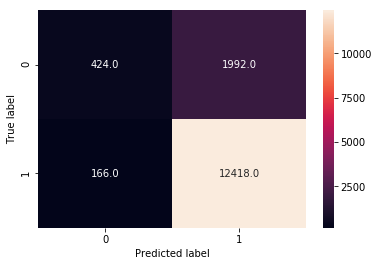

             precision    recall  f1-score   support

          0       0.72      0.18      0.28      2416
          1       0.86      0.99      0.92     12584

avg / total       0.84      0.86      0.82     15000



In [ ]:
test_results(best_k,X_tr,X_cv,X_te,y_train_ncv,y_cv,y_test,'brute')


### KNN-KDtree

In [ ]:
neighbors = list(range(1, 40, 2))
knn_df = knn_apply(neighbors,X_tr, X_cv, y_train_ncv, y_cv,'kd_tree')

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [33:57<00:00, 101.85s/it]


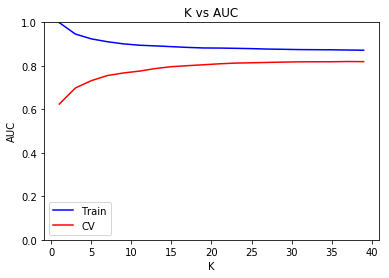

37 is the optimal k 


In [ ]:
# Please write all the code with proper documentation
k_vs_AUC_CV_Train(neighbors,knn_df['AUC_train'],knn_df['AUC_CV'])
best_k_row = knn_df.loc[knn_df['AUC_CV'] == max(knn_df['AUC_CV'] )]
best_k = int(best_k_row.iloc[0]['k'])
print(str(best_k) + " is the optimal k ")

The AUC score for train data is :  0.8728028999684946
The AUC score for CV data is :  0.8198673302605537
The AUC score for test data is :  0.8264300983483704


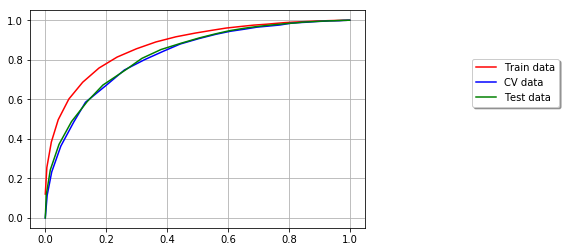

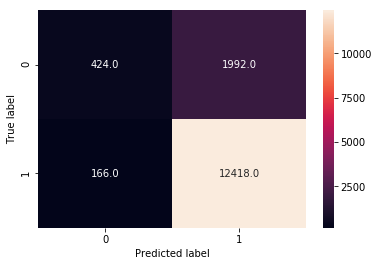

             precision    recall  f1-score   support

          0       0.72      0.18      0.28      2416
          1       0.86      0.99      0.92     12584

avg / total       0.84      0.86      0.82     15000



In [ ]:
test_results(best_k,X_tr,X_cv,X_te,y_train_ncv,y_cv,y_test,'kd_tree')


# Summary

In [ ]:
# Please compare all your models using Prettytable library

bow_brute = ['BoW - Brute',0.8,0.75,0.75]
bow_kdtree = ['BoW - kdtree',0.8,0.74,0.74]
tfidf_brute = ['TFIDF - Brute',0.82,0.59,0.57]
tfidf_kdtree = ['TFIDF - kdtree',0.85,0.58,0.57]
avgw2v_brute = ['AVG W2V - Brute',0.89,0.86,0.87]
avgw2v_kdtree = ['AVG W2V - kdtree',0.89,0.86,0.87]
tfidfw2v_brute = ['TFIDF W2V - Brute',0.87,0.81,0.83]
tfidfw2v_kdtree = ['TFIDF W2V - kdtree',0.87,0.82,0.83]

In [ ]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorization","AUC Train " ,"AUC CV ", "AUC Test "]

x.add_row(bow_brute)
x.add_row(bow_kdtree)
x.add_row(tfidf_brute)
x.add_row(tfidf_kdtree)
x.add_row(avgw2v_brute)
x.add_row(avgw2v_kdtree)
x.add_row(tfidfw2v_brute)
x.add_row(tfidfw2v_kdtree)
print(x)

+--------------------+------------+---------+-----------+
|   Vectorization    | AUC Train  | AUC CV  | AUC Test  |
+--------------------+------------+---------+-----------+
|    BoW - Brute     |    0.8     |   0.75  |    0.75   |
|    BoW - kdtree    |    0.8     |   0.74  |    0.74   |
|   TFIDF - Brute    |    0.82    |   0.59  |    0.57   |
|   TFIDF - kdtree   |    0.85    |   0.58  |    0.57   |
|  AVG W2V - Brute   |    0.89    |   0.86  |    0.87   |
|  AVG W2V - kdtree  |    0.89    |   0.86  |    0.87   |
| TFIDF W2V - Brute  |    0.87    |   0.81  |    0.83   |
| TFIDF W2V - kdtree |    0.87    |   0.82  |    0.83   |
+--------------------+------------+---------+-----------+


# Observation

1. KNN is a very slow algorithm for text processing 
2. We have plotted AUC values since we are handling an imbalanced dataset
3. We are getting best results for AVG W2V with an AUC of 0.87
4. Despite having high training accuracy TFIDF performs bad with unseen data
5. KD_tree runs slow compared to Brute
6. Space required is also very high for KNN 
7. Only review text was considered . Using feature engineering techniques like including review text results could improve